### Multi-Layer Perceptron 

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit

In [46]:
# import the data
df = pd.read_csv('UBS_Cleaned_Date.csv')

In [47]:
# Change "date" column to ensure datetime type and drop weekends
df["date"] = pd.to_datetime(df["date"])

#### MPL With Features From Feature Selection Process

In [48]:
# TimeSeriesSplit the data
tss = TimeSeriesSplit(n_splits=5)

# Create feature dataframe based on feature selection results
X = df[["date", "Close", "Change_Close",
            "Wiki_Move", "Wiki_EMA_5", 
            "Wiki_Disparity_s_5", "Change_Google",
            "Google_MAvg_s_5", "Google_EMA_Move_5", 
            "Google_Disparity_s_Move", "Google_ROC_Move",
            "Google_RSI_Move", "Wiki_Disparity_s",
            "Stock_RSI_Move", "Google_MAvg_s_6", "Google_Move",
            "Stoch_Oscillator_14", "target_1"
            ]]

X = X.set_index("date")

X = X.dropna()

# Create y target dataset
y = df["target_1"]

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [49]:
pd.DataFrame(X.isna().sum()).T

,Close,Change_Close,Wiki_Move,Wiki_EMA_5,Wiki_Disparity_s_5,Change_Google,Google_MAvg_s_5,Google_EMA_Move_5,Google_Disparity_s_Move,Google_ROC_Move,Google_RSI_Move,Wiki_Disparity_s,Stock_RSI_Move,Google_MAvg_s_6,Google_Move,Stoch_Oscillator_14,target_1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
# Print index of train and test data to check that they are split correctly
print(X_train.index)
print(X_test.index)

DatetimeIndex(['2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31',
               '2019-02-01', '2019-02-04', '2019-02-05', '2019-02-06',
               '2019-02-07', '2019-02-08',
               ...
               '2021-09-08', '2021-09-09', '2021-09-10', '2021-09-13',
               '2021-09-14', '2021-09-15', '2021-09-16', '2021-09-17',
               '2021-09-20', '2021-09-21'],
              dtype='datetime64[ns]', name='date', length=641, freq=None)
DatetimeIndex(['2021-09-22', '2021-09-23', '2021-09-24', '2021-09-27',
               '2021-09-28', '2021-09-29', '2021-09-30', '2021-10-01',
               '2021-10-04', '2021-10-05',
               ...
               '2022-03-16', '2022-03-17', '2022-03-18', '2022-03-21',
               '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-25',
               '2022-03-28', '2022-03-29'],
              dtype='datetime64[ns]', name='date', length=128, freq=None)


In [51]:
# Standardize the data
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train)
X_test_pca = scaler.fit_transform(X_test)

In [52]:
# Build MPL model
n_features = X_train_pca.shape[1]
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(n_features,)))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=10)
history

# predict on test data
y_pred = model.predict(X_test)

Epoch 1/50
65/65 [==============================] - 2s 10ms/step - loss: 11.4709 - accuracy: 0.5008 - val_loss: 12.3128 - val_accuracy: 0.5547
Epoch 2/50
65/65 [==============================] - 0s 4ms/step - loss: 3.3789 - accuracy: 0.4602 - val_loss: 6.1435 - val_accuracy: 0.5625
Epoch 3/50
65/65 [==============================] - 0s 4ms/step - loss: 2.4314 - accuracy: 0.4914 - val_loss: 8.1727 - val_accuracy: 0.5703
Epoch 4/50
65/65 [==============================] - 0s 8ms/step - loss: 3.3002 - accuracy: 0.5257 - val_loss: 5.2608 - val_accuracy: 0.5547
Epoch 5/50
65/65 [==============================] - 1s 8ms/step - loss: 3.1975 - accuracy: 0.5133 - val_loss: 5.3316 - val_accuracy: 0.5625
Epoch 6/50
65/65 [==============================] - 0s 5ms/step - loss: 3.3616 - accuracy: 0.5226 - val_loss: 6.1509 - val_accuracy: 0.5703
Epoch 7/50
65/65 [==============================] - 0s 6ms/step - loss: 2.1709 - accuracy: 0.4883 - val_loss: 6.2137 - val_accuracy: 0.5781
Epoch 8/50
65/65 

<AxesSubplot:>

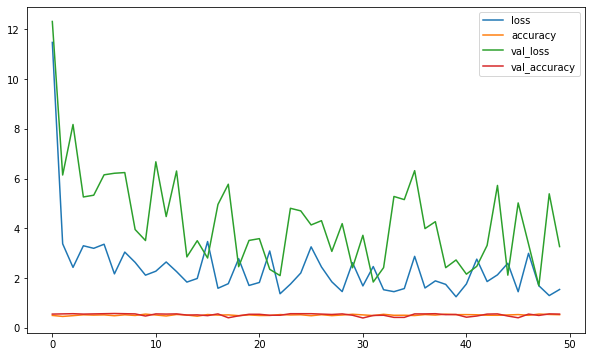

In [53]:
pd.DataFrame(history.history).plot(figsize=(10,6))

#### MPL With PCA For Feature Reduction

In [54]:
# Time series train/test split
tss= TimeSeriesSplit(n_splits=5)

# Keep all features, but remove the five target variables
X = df.iloc[:, :-5]
X = X.set_index("date")

# Create series for target 
y = df.iloc[:, -1]

# Split tranining and test data by date
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [55]:
# Print index of train and test data to check that they are split correctly
print(X_train.index)
print(X_test.index)

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2021-08-30', '2021-08-31', '2021-09-01', '2021-09-02',
               '2021-09-03', '2021-09-07', '2021-09-08', '2021-09-09',
               '2021-09-10', '2021-09-13'],
              dtype='datetime64[ns]', name='date', length=676, freq=None)
DatetimeIndex(['2021-09-14', '2021-09-15', '2021-09-16', '2021-09-17',
               '2021-09-20', '2021-09-21', '2021-09-22', '2021-09-23',
               '2021-09-24', '2021-09-27',
               ...
               '2022-03-17', '2022-03-18', '2022-03-21', '2022-03-22',
               '2022-03-23', '2022-03-24', '2022-03-25', '2022-03-28',
               '2022-03-29', '2022-03-30'],
              dtype='datetime64[ns]', name='date', length=135, freq=None)


In [58]:
# PCA feature reduction. 40 components is enough to explain ~85% of the variance (refer to Feture_selection notebook)
sklearn_pca = PCA(n_components=40)
X_train_pca = sklearn_pca.fit_transform(X_train)
X_test_pca = sklearn_pca.transform(X_test)

# Standardize the data 
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.fit_transform(X_test_pca)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Build MPL model
n_features = X_train_pca.shape[1]
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(n_features,)))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model
history = model.fit(X_train_pca, y_train, epochs=50, validation_data=(X_test_pca, y_test), batch_size=10)
history

# predict on test data
y_pred = model.predict(X_test_pca)

Epoch 1/50
61/61 [==============================] - 0s 3ms/step - loss: 0.7138 - accuracy: 0.5358 - val_loss: 0.7288 - val_accuracy: 0.4917
Epoch 2/50
61/61 [==============================] - 0s 1ms/step - loss: 0.6567 - accuracy: 0.6123 - val_loss: 0.7152 - val_accuracy: 0.5417
Epoch 3/50
61/61 [==============================] - 0s 1ms/step - loss: 0.6264 - accuracy: 0.6356 - val_loss: 0.7163 - val_accuracy: 0.5500
Epoch 4/50
61/61 [==============================] - 0s 2ms/step - loss: 0.6027 - accuracy: 0.6789 - val_loss: 0.7118 - val_accuracy: 0.5583
Epoch 5/50
61/61 [==============================] - 0s 2ms/step - loss: 0.5841 - accuracy: 0.6938 - val_loss: 0.7110 - val_accuracy: 0.5583
Epoch 6/50
61/61 [==============================] - 0s 2ms/step - loss: 0.5701 - accuracy: 0.7138 - val_loss: 0.7161 - val_accuracy: 0.5833
Epoch 7/50
61/61 [==============================] - 0s 2ms/step - loss: 0.5569 - accuracy: 0.7171 - val_loss: 0.7172 - val_accuracy: 0.6000
Epoch 8/50
61/61 [==

<AxesSubplot:>

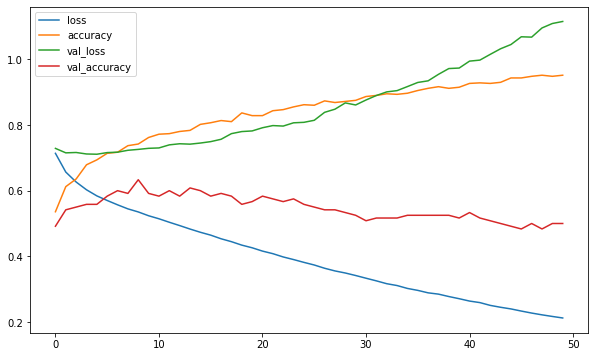

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,6))